In [1]:
# For data importing and reporting
import importlib
import time
import numpy as np
import sklearn.preprocessing
import tensorflow as tf
import matplotlib.pyplot as plt



In [2]:
from ddgan import GAN
from ddgan import *

In [3]:
kwargs = {
    "nsteps" : 10,
    "ndims" : 5,
    "batch_size" : 160,
    "batches" : 5,
    "seed" : 143,
    "epochs" : 35000,
    "n_critic" : 10,
    "gen_learning_rate" : 5e-4,
    "disc_learning_rate" : 5e-4,
}

gan = GAN(**kwargs)
gan.setup(find_old_model=True)
set_seed(gan.seed)

ndims_latent_input = gan.ndims

csv_data = np.load('../data/processed/single/pod_coeffs_field_Velocity.npy', )
csv_data = csv_data[0,:,:]

csv_data = np.float32(csv_data.T)

print('type and shape (nPOD by nTrain) of POD coeffs from csv file', type(csv_data), csv_data.shape, csv_data.dtype)

looking for previous saved models
type and shape (nPOD by nTrain) of POD coeffs from csv file <class 'numpy.ndarray'> (1214, 15) float32


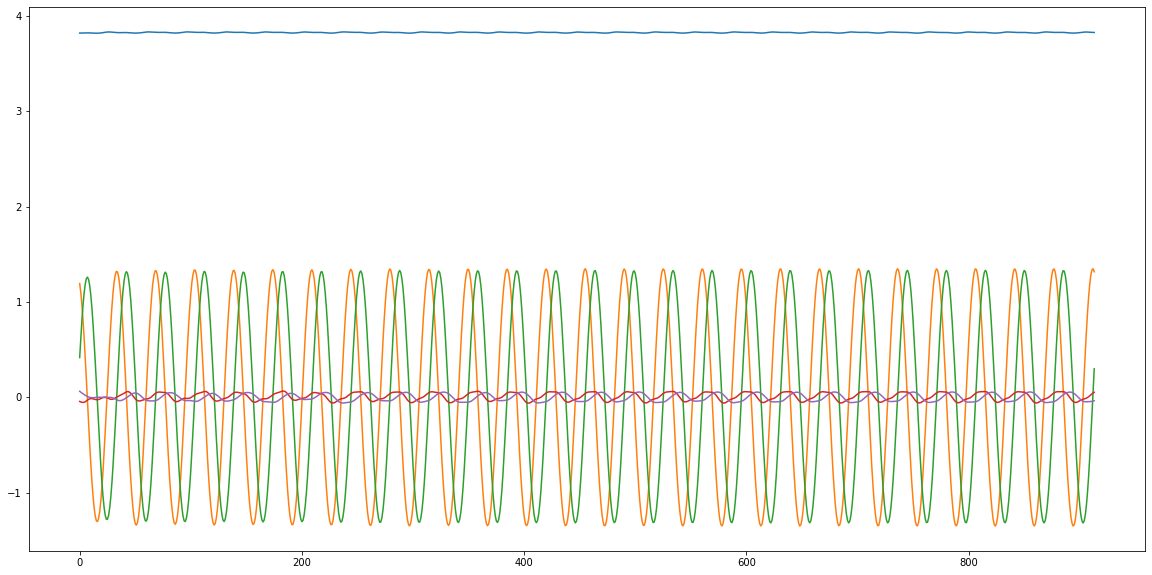

In [4]:
fig, ax = plt.subplots(1,1, figsize=[20,10])
ax.plot(csv_data[300:,0:5])
plt.show()

In [5]:
csv_data = csv_data[300:,:5]

In [6]:
from sklearn.preprocessing import MinMaxScaler
scaling = sklearn.preprocessing.MinMaxScaler(feature_range=[-1,1])
csv_data = scaling.fit_transform(csv_data)

In [7]:
step_size = 2
nTrain = 809 
t_begin = 0
t_end = nTrain - gan.nsteps + 1
training_data = np.zeros((t_end, gan.ndims * gan.nsteps), dtype=np.float32) # nTrain by nsteps*nPOD # 'float32' or np.float32


input_to_GAN = tf.random.normal([training_data.shape[0], 10])
input_to_GAN = input_to_GAN.numpy()

for step in range(gan.nsteps):
    training_data[:,step*gan.ndims:(step+1)*gan.ndims] = csv_data[t_begin+(step*step_size) : t_end+(step*step_size),:]
print('Shape of training data for the GAN', training_data.shape, training_data.dtype)

Shape of training data for the GAN (800, 50) float32


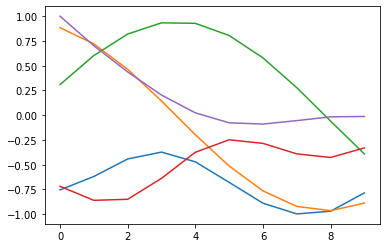

In [ ]:
plt.plot(training_data[0,0::5])
plt.plot(training_data[0,1::5])
plt.plot(training_data[0,2::5])
plt.plot(training_data[0,3::5])
plt.plot(training_data[0,4::5])

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
%tensorboard --logdir ./logs/gradient_tape/ --port 6007
%reload_ext tensorboard

In [ ]:
t0 = time.time()
gan.learn_hypersurface_from_POD_coeffs(training_data)
t_train = time.time() - t0

In [ ]:
kwargs_opt = {
    "start_from" : 100,
    "nPOD" : 5,
    "nLatent" : 10,
    "npredictions" : 100,
    "optimizer_epochs" : 1001,
    "gan" : gan,
    "bounds" : 10,
}

optimizer = Optimize(**kwargs_opt)
#flds = optimizer.predict(training_data, scaling=scaling)
flds = optimizer.predict(training_data, scaling=None)

Time step: 	 0
tf.Tensor(
[[ 0.7190552   0.80553347 -0.5824531  -0.08239041 -0.5941767   0.48931885
   0.9567215  -0.26542112  0.15934286 -0.6625014   0.33966064  0.98863035
   0.08607548  0.406056   -0.7220758   0.29058838  0.89681166  0.42727724
   0.57382065 -0.6842876   0.35009766  0.6918823   0.7145061   0.6776228
  -0.51996535  0.41918945  0.39803118  0.91113055  0.7872077  -0.27393985
   0.3390503   0.0514464   0.99182636  0.9127792  -0.00697767  0.09832764
  -0.30099234  0.9469091   0.8893235   0.2439743  -0.2277832  -0.61303836
   0.78255844  0.61383325  0.4566644 ]], shape=(1, 45), dtype=float32)
Optimizer epoch: 	 0
Optimizer epoch: 	 100
Optimizer epoch: 	 200
Optimizer epoch: 	 300
Optimizer epoch: 	 400
Optimizer epoch: 	 500
Optimizer epoch: 	 600
Optimizer epoch: 	 700
Optimizer epoch: 	 800
Optimizer epoch: 	 900
Optimizer epoch: 	 1000
Time step: 	 1
tf.Tensor(
[[ 0.48931885  0.95672148 -0.26542112  0.15934286 -0.66250139  0.33966064
   0.98863035  0.08607548  0.40605

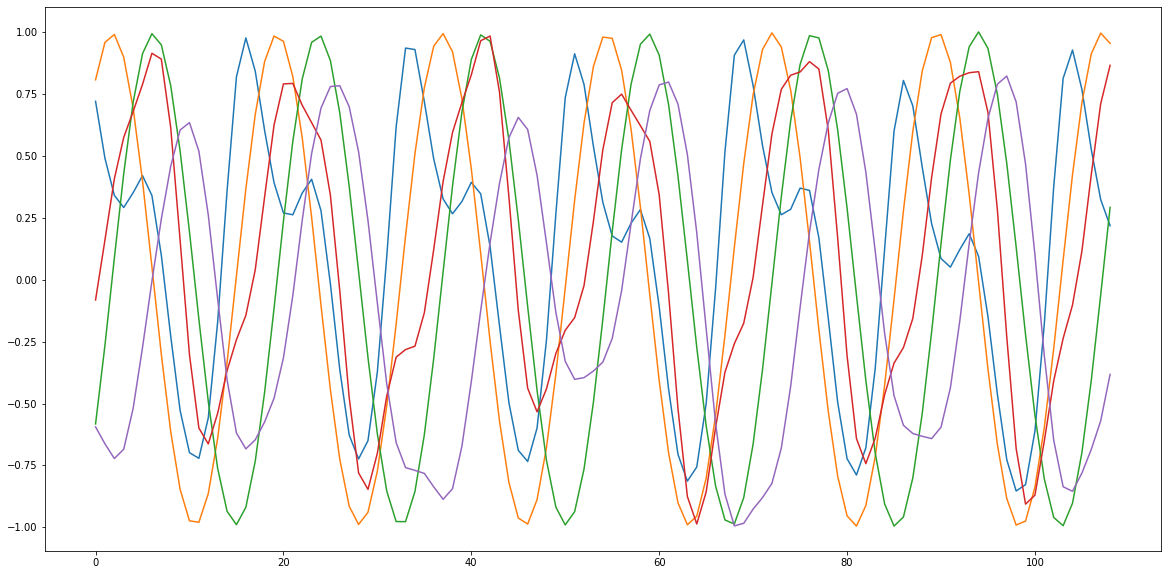

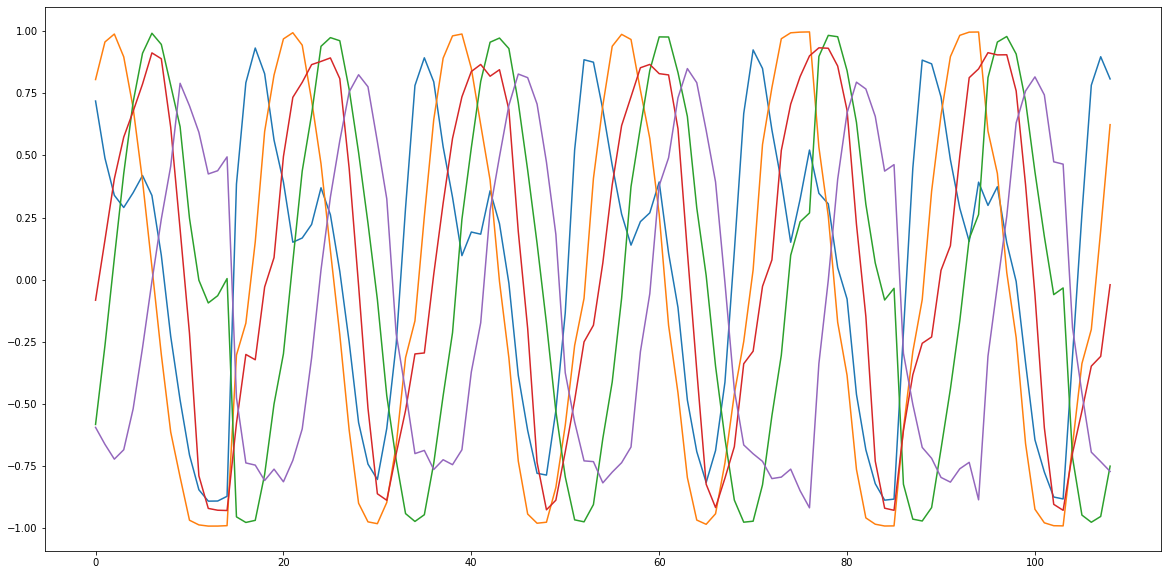

In [ ]:
mfig, ax = plt.subplots(1,1, figsize=[20,10])
#ax.plot(csv_data[100:115,:])
ax.plot(csv_data[optimizer.start_from:optimizer.start_from + len(flds)*step_size:step_size,:])
plt.show()

#scaling.inverse_transform(flds)
fig, ax = plt.subplots(1,1, figsize=[20,10])
ax.plot(flds[:])
plt.show()

In [ ]:
#scaling.inverse_transform(flds)
fig, ax = plt.subplots(1,1, figsize=[20,10])
ax.plot(np.abs(csv_data[optimizer.start_from:optimizer.start_from + len(flds)*step_size:step_size,:]-flds[:]))
plt.show()

In [ ]:
fig, ax = plt.subplots(1,1, figsize=[20,10])
#ax.plot(csv_data[100:115,:])
ax.plot(csv_data[:24,:])
plt.show()

In [ ]:
fig, ax = plt.subplots(1,1, figsize=[20,10])
ax.plot(flds[:24])
plt.show()

In [ ]:
basis = np.load('../data/processed/pod_basis_field_Velocity.npy')
np.save('../data/reconstructed/velocity_field.npy', np.reshape((basis[:,:gan.ndims] @ scaling.inverse_transform((flds)).T), [1,2,221,42,-1]))

In [ ]:
basis[:,:10].shape